# Predicting Survival of Passengers on the RMS Titanic

In this notebook various data from the passengers aboard the RMS is loaded. This data is then analyzed for significant correlation with surviving the disaster. Ultimately, models are produced to predict the survivorship of passengers based on details of their passage.

Let's import the libraries we'll need.

In [2]:
import pandas as pd
import numpy as np
import os
from scipy import stats
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import neighbors
from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

matplotlib.rcParams.update({'font.size': 16})

The data is imported and a several rows are printed.

In [3]:
df = pd.read_csv('train.csv')
print(df.shape)
no_passengers = df.shape[0]
print(df.dtypes)
df[0:10]

(891, 12)
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Three columns have NaN. Let's address the port of Embarkation as well as age.

In [4]:
len(df[df['Cabin'].isnull()])/len(df)

0.7710437710437711

# MISSING DATA

## Port of Embarkation

We inspect the Embarked column for missing values.

In [5]:
df[df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Two values are found. Let's build a model based on everyone else on board and see if we can guess where Miss Icard and Mrs. Stone got onboard. We assume that the passenger's fare, class, and where they embarked are related. Let's define the variables.

In [6]:
df2 = df.loc[:,['Pclass','Fare','Embarked']]
df2.dropna(inplace=True) #Dropping the target of our model

# Prepare X
X = np.array(df2.loc[:,['Pclass','Fare']]) # Casting to an np.arr
scaler = preprocessing.Normalizer().fit(X) 
X = scaler.transform(X)  # Scaling values

# Prepare y
ports = ['C','Q','S']
emb_dum = df2['Embarked'].replace(ports,[0,1,2]) # Transforming categorical data into numeric
y = np.array(emb_dum) # Casting to an np.arr

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)




A classifier clf is defined and the data fit to it.

In [7]:
fig = plt.figure(figsize=(25,20))
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train) 


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

<Figure size 1800x1440 with 0 Axes>

In [8]:
f1_score(y_test,clf.predict(X_test),average='weighted')

0.9106667918270284

<Figure size 576x288 with 0 Axes>

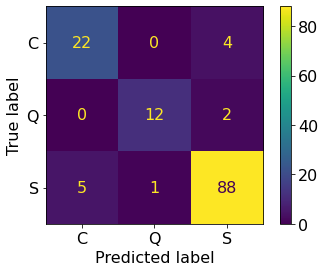

In [9]:
plt.figure(figsize=(8,4))
c_mat = confusion_matrix(y_test,clf.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix = c_mat, display_labels=ports)
disp.plot(values_format='d')
plt.savefig('./embarked_dt.png',bbox_inches='tight',dpi=300)


In [10]:
dot_data = tree.export_graphviz(clf, out_file='embarked_dt.dot', 
                     feature_names=['Pclass','Fare'],
                    filled=True, rounded=True,  
                     special_characters=True)
graph = pgv.AGraph('./embarked_dt.dot')  
#graph.draw()

NameError: name 'pgv' is not defined

Predicting the port of our passengers:

In [11]:
x = scaler.transform(np.array([1,80]).reshape(1,-1)) # Both passengers paid 80 pounds for a first class ticket
print('[0,1,2]')
print(ports)
print(clf.predict(x))

[0,1,2]
['C', 'Q', 'S']
[2]


The model calculates the port of embarkation for both passengers to be Southampton. Southampton is imputed.

In [12]:
df['Embarked'].fillna('S', inplace=True)

Let's check to see if we missed anyone

In [13]:
df[df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


We did not miss anyone. Let's now look towards age.

## Age

In [14]:
df[df['Age'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


Oh dear. There is a significant number of passengers whose age is unknown. Again we will build a model with the objective of calculating the age of passengers we don't know. This time a k-Neighbors regressor is used and fit to the passengers we have data for. First let's note the indicies of the passengers we will be targeting.

In [15]:
nullage = df[df['Age'].isnull()].index.tolist()
nullage[0:5]

[5, 17, 19, 26, 28]

18999
DONE


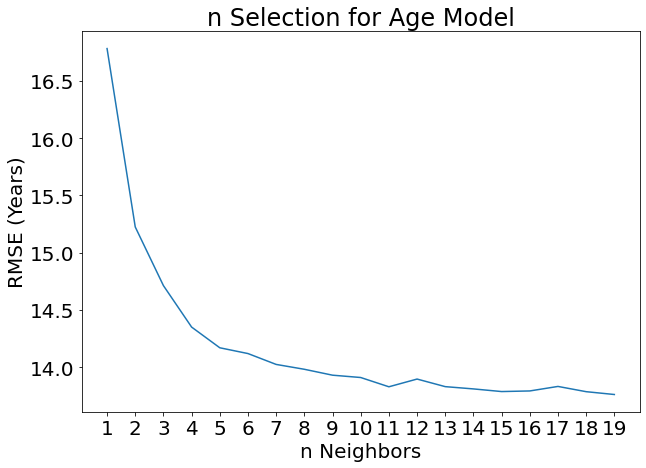

In [17]:
matplotlib.rcParams.update({'font.size': 20})

df2 = df.loc[:,['Pclass','Sex','SibSp','Parch','Fare','Embarked','Age']] # These are our variables of interest

# Quick and dirty: Categorical variables are replaced with an integer
df2['Sex'].replace(['female','male'],[0,1],inplace=True) 
df2['Embarked'].replace(['C','Q','S'],[0,1,2],inplace=True)

# A copy of out model inputs is made for graphing later
df3 = df2.copy()

# Remove NaNs and cast to np.arr
df2.dropna(inplace=True)
data = np.array(df2)

# Defining model inputs
X = data[:,:6]
y = data[:,6]

list_knn = []

its=1000
neighbor_range = range(1,20)
index = 0
for i in neighbor_range:
    RMSE_LIST= []
    for j in range(0,its):
    
        X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
        # Defining a classifier. 
        n_neighbors = i
        knn = neighbors.KNeighborsRegressor(n_neighbors,weights='distance',algorithm='brute',n_jobs=-1)
        knn.fit(X_train,y_train)

        E = np.subtract(knn.predict(X_test),y_test)
        SE = np.power(E,2)
        MSE = np.sum(SE/len(y_test))
        RMSE = np.sqrt(MSE)
        RMSE_LIST.append(RMSE)
        os.sys.stdout.write(f'{index}\r')
        index = index + 1
    
    list_knn.append(np.array(RMSE_LIST).mean())
print('\nDONE')
plt.figure(figsize=(10,7))
plt.plot(neighbor_range,list_knn)
plt.title('n Selection for Age Model')
plt.ylabel('RMSE (Years)')
plt.xlabel('n Neighbors')
plt.xticks(neighbor_range)
#plt.savefig('./age_rmse.png',bbox_inches='tight',dpi=300)
plt.show()

Model RMSE: 15.6


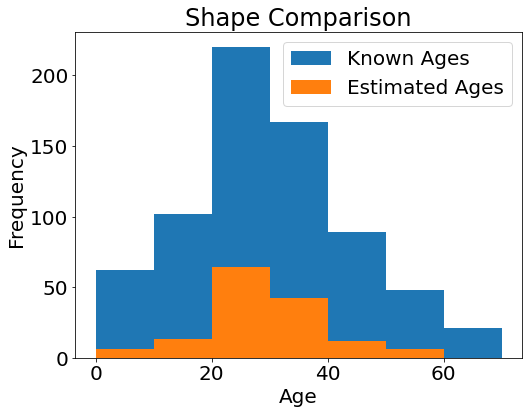

In [19]:
df2 = df.loc[:,['Pclass','Sex','SibSp','Parch','Fare','Embarked','Age']] # These are our variables of interest

# Quick and dirty: Categorical variables are replaced with an integer
df2['Sex'].replace(['female','male'],[0,1],inplace=True) 
df2['Embarked'].replace(['C','Q','S'],[0,1,2],inplace=True)

# A copy of out model inputs is made for graphing later
df3 = df2.copy()

# Remove NaNs and cast to np.arr
df2.dropna(inplace=True)
data = np.array(df2)

# Defining model inputs
X = data[:,:6]
y = data[:,6]

# The inputs have many different scales.
# They are normalized.
scaler = preprocessing.Normalizer().fit(X)
T = np.array(df3[df3['Age'].isnull()])
T = scaler.transform(T[:,:6])
X = scaler.transform(X)
model_RMSE = []
for i in range (0,1000):
    X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

    # Defining a classifier. 
    n_neighbors = 4
    knn = neighbors.KNeighborsRegressor(n_neighbors,weights='distance',algorithm='brute',n_jobs=-1)
    knn.fit(X_train,y_train)

    E = np.subtract(knn.predict(X_test),y_test)
    SE = np.power(E,2)
    MSE = np.sum(SE)/len(y_test)
    RMSE = np.sqrt(MSE)
    model_RMSE.append(RMSE)
print(f'Model RMSE: {RMSE:.1f}')

# Plot the known ages with the modeled ages for comparison of shape.
plt.figure(figsize=(8,6))
plt.hist(df['Age'],color='C0',bins=np.arange(0,80,10))
plt.hist(knn.predict(X_test),color='C1',bins=np.arange(0,80,10))
plt.legend(['Known Ages','Estimated Ages'])
plt.title('Shape Comparison')
plt.ylabel('Frequency')
plt.xlabel('Age')
#plt.savefig('./agemodeldist.png', dpi=300)
# Replace unknown ages with modeled ones.
df.iloc[nullage,5] = knn.predict(T)

plt.show()

14.134353617595822
0.8135773875938206


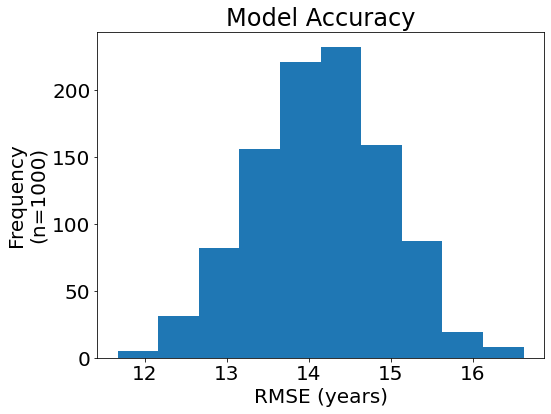

In [20]:
bins = np.linspace(-3,3,13)
plt.figure(figsize=(8,6))
#plt.hist(stats.zscore(model_RMSE),bins=bins)
plt.hist(model_RMSE)
plt.title('Model Accuracy')
plt.ylabel('Frequency\n(n=1000)')
plt.xlabel('RMSE (years)')
stats.describe(model_RMSE)
plt.savefig('agermsefreq.png',bbox_inches='tight',dpi=300)
print(np.mean(model_RMSE))
print(np.std(model_RMSE))

The shapes of these distributions are visually consistent. The RMSE of the fit is 13 years or about half a human generation. There is no immediate reason to reject these results.

In [21]:
df[df['Age'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


Every passenger now has an age and a port of Embarkation. Moving on, we begin to build our model of who survived.

An empty list is defined. As I move through each variable, those that have significant correlation with the Survived variable will be appended to the list.

In [22]:
model = [] 

# BY SEX

An exploration is made into the correlation and significance of sex on surviving the shipwreck.

In [23]:
sexes = ['male','female']
bysex = np.zeros((2,2))
for i in range(0,len(sexes)):
    bysex[i] = df[df['Sex'] == sexes[i]]['Survived'].value_counts().sort_index()
bysex

array([[468., 109.],
       [ 81., 233.]])

The first row of this array are all male. The second row is all female. The first column represents the number of passengers who did not survive. The second column represents the number of passengers who did survive. Looks like males are less likely to survive than females. Let's check rates

In [24]:
males_rate = bysex[0][1]/np.sum(bysex[0])
females_rate = bysex[1][1]/np.sum(bysex[1])
print('Survival rate of:')
print('\tmales:\t\t',f'{males_rate:.3f}')
print('\tfemales:\t',f'{females_rate:.3f}')

Survival rate of:
	males:		 0.189
	females:	 0.742


Indeed, there is quite a contrast between the two rates. Let's visualize survivorship.

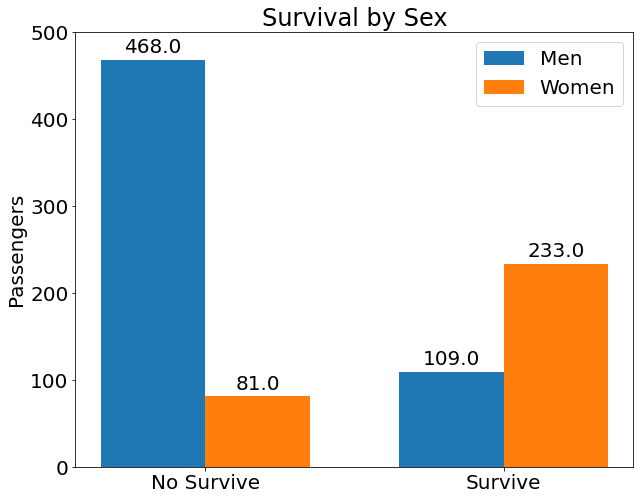

In [25]:
labels = ['No Survive', 'Survive']
male = bysex[0]
female = bysex[1]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - width/2, male, width, label='Men')
rects2 = ax.bar(x + width/2, female, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Passengers')
ax.set_title('Survival by Sex')
ax.set_xticks(x)
ax.set_ylim(0,500)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

There are more males on board than there are females. Let's do an apples to apples comparison and visualize rate.

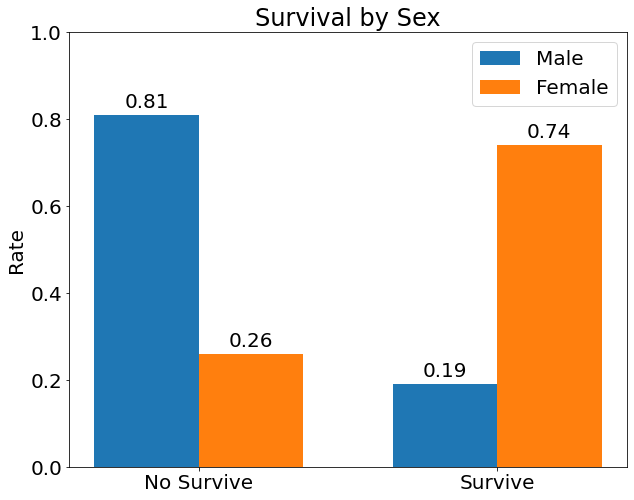

In [26]:
labels = ['No Survive', 'Survive']
male = np.round(bysex[0]/np.sum(bysex[0]),2)
female = np.round(bysex[1]/np.sum(bysex[1]),2)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - width/2, male, width, label='Male')
rects2 = ax.bar(x + width/2, female, width, label='Female')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rate')
ax.set_title('Survival by Sex')
ax.set_xticks(x)
ax.set_ylim(0,1)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)

plt.show()

Now we calculate Pearson's r for being a male and surviving the disaster for inclusion in the final model.

In [27]:
df['male'] = df['Sex'] == 'male' # Create a column to indicate whether or not the passenger is male
df['male'].replace([True,False],[1,0],inplace=True) # Converting the results to a numeric value

# Define the input
X = np.array(df['male'])
y = np.array(df['Survived'])

# Calculate correlation
pear = stats.pearsonr(X,y)
print('is_male vs Survived')
print(f'\tCorrelation: {pear[0]:.2f}')
print(f'\tp-val: {pear[1]:.2e}')

is_male vs Survived
	Correlation: -0.54
	p-val: 1.41e-69


#### Discussion
There is a statistically significant indirect correlation between being a male and survival. Our model should include whether or not the passenger is male.

In [28]:
model.append('male')
model

['male']

# BY PORT of EMBARKATION


An exploration is made into the correlation and significance of port of embarkation on surviving the shipwreck. We define a list of all ports

In [29]:
ports = df['Embarked'].unique()
ports

array(['S', 'C', 'Q'], dtype=object)

In [30]:
# Now we calculate and print the survival rate of passengers vs where the boarded.
byport = np.zeros((len(ports),2))
byport
for i in range(0,len(ports)):
    byport[i] = df[df['Embarked'] == ports[i]]['Survived'].value_counts().sort_index()
print('Survival rate of:')
for i in range(0,len(ports)):
    print(f'\t{ports[i]}: {byport[i][1]/np.sum(byport[i]):.2f}')

Survival rate of:
	S: 0.34
	C: 0.55
	Q: 0.39


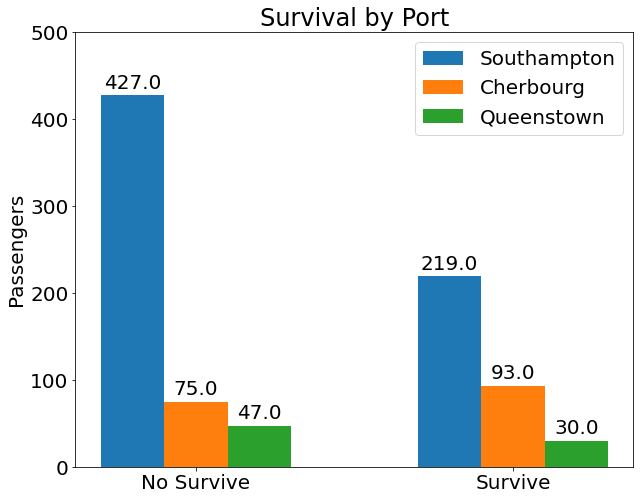

In [31]:
# Visualizing these rates
labels = ['No Survive', 'Survive']
S = byport[0]
C = byport[1]
Q = byport[2]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - width, S, width, label='Southampton')
rects2 = ax.bar(x , C, width, label='Cherbourg')
rects3 = ax.bar(x + width, Q, width, label='Queenstown')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Passengers')
ax.set_title('Survival by Port')
ax.set_xticks(x)
ax.set_ylim(0,500)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

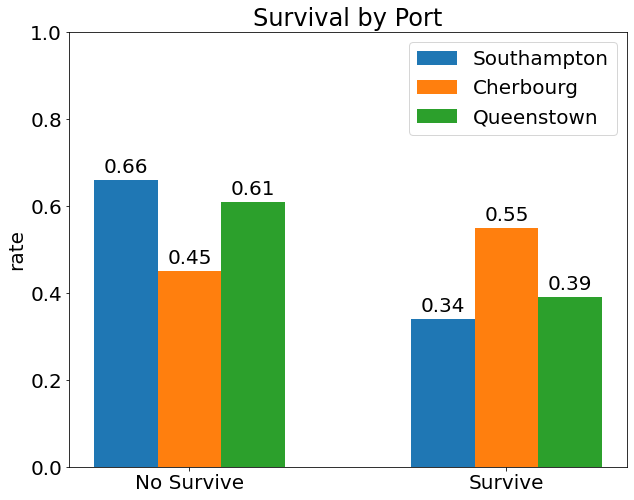

In [32]:
# Now we do the same for the rate of surviving at each port.
labels = ['No Survive', 'Survive']
S = np.round(byport[0]/np.sum(byport[0]),2)
C = np.round(byport[1]/np.sum(byport[1]),2)
Q = np.round(byport[2]/np.sum(byport[2]),2)

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - width, S, width, label='Southampton')
rects2 = ax.bar(x , C, width, label='Cherbourg')
rects3 = ax.bar(x + width, Q, width, label='Queenstown')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('rate')
ax.set_title('Survival by Port')
ax.set_xticks(x)
ax.set_ylim(0,1)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

These are great pictures, but do they mean anything significant? Now I calculate the Pearson R correlation for the relationship between port and surviving.

In [33]:
portdum = pd.get_dummies(df['Embarked'])
ports = np.array(portdum.columns)
X = np.array(portdum)
for i in range(0,3):
    if stats.pearsonr(X[:,i],y)[0] < 0.05:
        print(f'Embarked {ports[i]}:')
        print(f'\tcorr {stats.pearsonr(X[:,i],y)[0]:.3e}')
        print(f'\tp-value {stats.pearsonr(X[:,i],y)[1]:.3e}')
        model.append(f'port_{ports[i]}')
        print()

Embarked Q:
	corr 3.650e-03
	p-value 9.134e-01

Embarked S:
	corr -1.497e-01
	p-value 7.223e-06



#### Discussion
These values suggest that embarking at Cherbourg has a statistically significant direct correlation with surviving. Southampton has a similar indirect correlation. There is no statisically significant correlation between embarking at Queenstown and survival. Our model should include whether the passenger embarked at Cherbourg or Southampton.

In [34]:
model

['male', 'port_Q', 'port_S']

# BY DECK

Each cabin number is prefixed with a letter which indicates on which deck the passenger's cabin was. The cabin of all passengers is not known so for those without a known cabin(and deck) number we will create a group.

In [35]:
df.loc[:,['Cabin','Survived']][0:5]

,Cabin,Survived
0,NaN,0
1,C85,1
2,NaN,1
3,C123,1
4,NaN,0


In [36]:
# Replace NaN with '??' to indicate that the cabin number and deck for this passenger is unknown.
df['Cabin'].replace(np.nan,'??',inplace=True)

# A function to return which deck the passenger was on.
def get_deck(cabin):
    return str(cabin)[0]

df['deck'] = df['Cabin'].apply(get_deck)
decks = df['deck'].unique()
decks.sort()
print(decks)
df.loc[:,['deck','Survived']][0:5]

['?' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'T']


,deck,Survived
0,?,0
1,C,1
2,?,1
3,C,1
4,?,0


Now we have a list of all decks. Let's look into how this variable effects survival.

In [37]:
# Initialize an array
bydeck = np.zeros((len(decks),2))

# Loop through all decks and calculate number of survivors on each.
for i in range(0,len(decks)):
    if len(df[df['deck'] == decks[i]]['Survived']) > 1: # Did anyone survive on the deck?
        bydeck[i] = df[df['deck'] == decks[i]]['Survived'].value_counts().sort_index()
    elif df[df['deck'] == decks[8]]['Survived'].value_counts().index[0] == 0: # if no one survived, return 0
        bydeck[i] = [df[df['deck'] == decks[8]]['Survived'].value_counts(),0]

print('Survival rate of:')
for i in range(0,len(decks)):
    print(f'{decks[i]} {np.sum(bydeck[i]):.2f}')

Survival rate of:
? 687.00
A 15.00
B 47.00
C 59.00
D 33.00
E 32.00
F 13.00
G 4.00
T 1.00


The printout is informative, but not as revealing as a graph. Let's draw some axes.

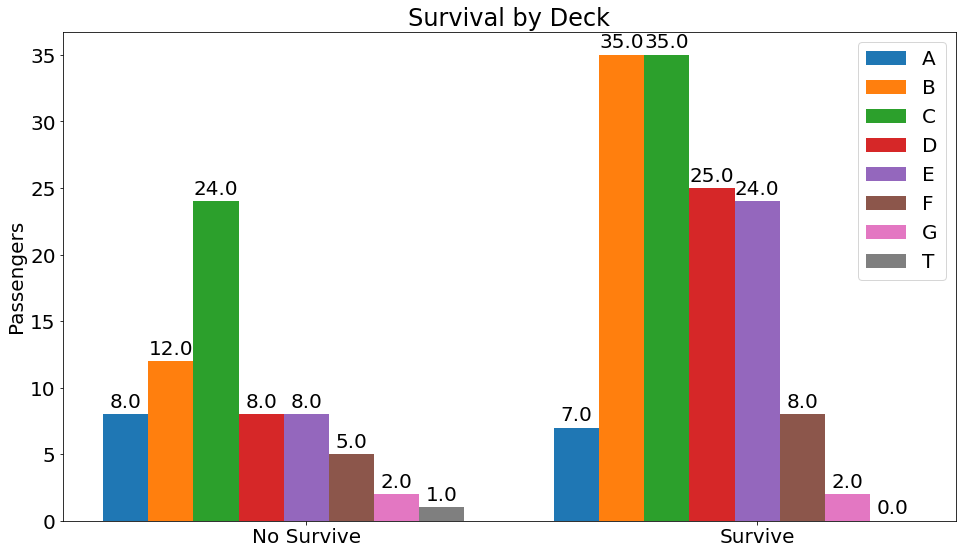

In [38]:
labels = ['No Survive', 'Survive']

x = np.arange(0,2)  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots(figsize=(16,9))

for i in range(1,len(decks)):
    b = ax.bar(x + (i-5)*width/5, bydeck[i], width/5, label=decks[i])
    autolabel(b)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Passengers')
ax.set_title('Survival by Deck')
ax.set_xticks(x)
#ax.set_ylim(0,505)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [39]:
# A snippet to generate distinct colors for our bars.
import colorsys
N = 2*len(np.unique(decks))
print('colors: {}'.format(N))
rgb_list = []
HSV_tuples = []
for x in range(1,N+1):
    if (x%2 == 0):
        HSV_tuples.append(((x-1)*1.0/N, 1.0, 0.325))
    else:
        HSV_tuples.append((x*1.0/N, 1.0, 0.75))
RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
for rgb in RGB_tuples:
        color = [int(255*rgb[0]),int(255*rgb[1]),int(255*rgb[2])]
        hxstr = '#'
        for c in color:
            hxstr = hxstr + '{0:0{1}X}'.format(c,2)
        rgb_list.append(hxstr)    


colors: 18


Let's also visualize survival rate per deck.

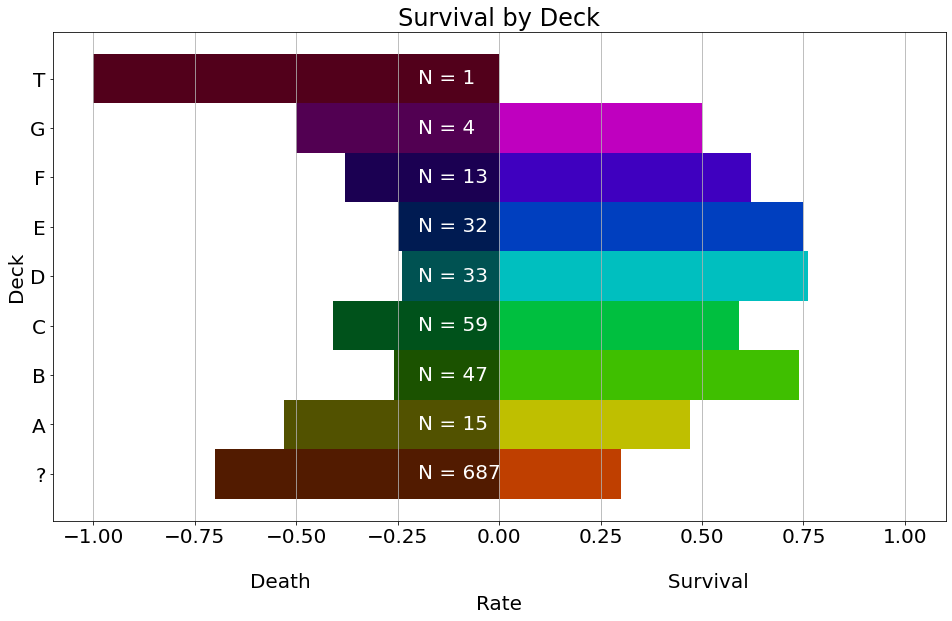

In [40]:
x = np.arange(-2.0,2.0)  # the label locations
width = 5.0  # the width of the bars

fig, ax = plt.subplots(figsize=(16,9))
rects = []
for i in range(0,len(decks)):
    b = plt.barh(i, np.round(bydeck[i,1]/np.sum(bydeck[i]),2), width/5, label=decks[i],color=rgb_list[2*i])
    nb = plt.barh(i, -np.round(bydeck[i,0]/np.sum(bydeck[i]),2), width/5, label=decks[i],color=rgb_list[2*i+1])
    plt.annotate(f'N = {str(int(np.sum(bydeck[i])))}',xy=[-0.20,i-0.1],c='white')
    rects.append(b)
ax.set_xlabel('\nDeath                                                        Survival\nRate')
ax.set_ylabel('Deck')
ax.set_title('Survival by Deck')
ax.set_yticks(range(0,9))
ax.set_xlim(-1.1,1.1)
ax.set_yticklabels(decks)
ax.grid(axis='x')
plt.show()

It looks like if the deck is known, seems to indicate that the passenger survived. In fact, I would say that if the deck is unknown there is a significant chance the passenger did not survive. To validate my claim, the Pearson r is calculated.

In [41]:
# Translate the categorical deck values into numeric types
deckdum = pd.get_dummies(df['deck'])
decks = np.array(deckdum.columns)

#Define input (y is still survivors)
X = np.array(deckdum)

# Loop through decks and check for correlation
print('Significance  p < 0.05')
print('==========================')
for i in range(0,len(decks)):
    pr = stats.pearsonr(X[:,i],y)
    significant = ( pr[1] < 0.05)
    if significant: # if a significant correlation is found, do stuff
        print(f'Deck {decks[i]} ')
        print(f'\tcorr {pr[0]:.3f}')
        print(f'\tp-value {pr[1]:.3e}')
        print(f'\tSignificant: {significant}')
        model.append(f'deck_{decks[i]}')
        print('+------------------------+')

Significance  p < 0.05
Deck ? 
	corr -0.317
	p-value 3.091e-22
	Significant: True
+------------------------+
Deck B 
	corr 0.175
	p-value 1.442e-07
	Significant: True
+------------------------+
Deck C 
	corr 0.115
	p-value 6.062e-04
	Significant: True
+------------------------+
Deck D 
	corr 0.151
	p-value 6.233e-06
	Significant: True
+------------------------+
Deck E 
	corr 0.145
	p-value 1.332e-05
	Significant: True
+------------------------+


#### Discussion
There is a statistically significant correlation between staying on Deck B, C, D, E and survival. Conversely, if the deck of the passenger is unknown there is a stronger correlation with not surviving. There is no significant correlation for the other decks A, F, G, & T. The significant decks should be included in our model.

In [42]:
model

['male', 'port_Q', 'port_S', 'deck_?', 'deck_B', 'deck_C', 'deck_D', 'deck_E']

# BY AGE

Since we filled in the missing age values, everyone on board now has an age value. Let's visualize the age distribution and investigate different age groups for correlation with surviving the disaster.

Let's make a histogram.

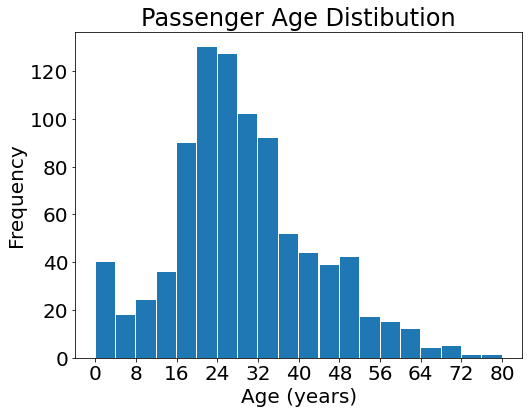

In [43]:
# Defining some parameters for our histogram
nbins = 20 # The number of bins in our histogram. More on this later.
ylim = df['Age'].max() # Maximum value for the histogram's x-axis
binwidth= ylim/nbins # The width of each bin

bins = np.arange(0,ylim,binwidth) # An array of evenly spaced bins "binwidth" apart from 0 to 80 years of age.


thedigital = np.digitize(df['Age'],bins,right=True) # assign each age to a bin
thecount = np.bincount(thedigital) # Count the members in each bin

# Create some axes
plt.figure(figsize=(8,6))
plt.bar(bins+binwidth/2,thecount[1:],width=binwidth*0.95)
plt.xticks(np.arange(0,88,8))
plt.title('Passenger Age Distibution')
plt.ylabel('Frequency')
plt.xlabel('Age (years)')
plt.savefig('./agedist.png',bbox_inches='tight',dpi=300)
plt.show()

Let's calculate some descriptive statistics for discussion.

In [44]:
desc = stats.describe(df['Age'])

stats_ = ['nobs\t','minmax\t','mean\t','variance','skewness','kurtosis']
for i in range(0,len(stats_)):
    print(f'{stats_[i]}:\t{desc[i]}')

mode = stats.mode(df['Age'])
print(f'\nmode\t:\t{mode[0][0]} ({mode[1][0]})')

median = np.median(np.array(df['Age']))
print(f'median\t:\t{median:.1f}')

stdev= np.std(df['Age'])
print(f'Std.Dev\t:\t{stdev:.1f}')

IQR = stats.iqr(df['Age'])
_25pct = desc[2] - IQR/2
_50pct = desc[2]
_75pct = desc[2] + IQR/2
print(f'\nIQR\t:\t{IQR:.1f}')
print(f'25%\t:\t{_25pct:.1f}')
print(f'50%\t:\t{_50pct:.1f}')
print(f'75%\t:\t{_75pct:.1f}')

nobs	:	891
minmax	:	(0.42, 80.0)
mean	:	29.561181143308534
variance:	193.48469069039407
skewness:	0.4117141257971412
kurtosis:	0.2923446392726867

mode	:	19.0 (30)
median	:	28.0
Std.Dev	:	13.9

IQR	:	16.6
25%	:	21.2
50%	:	29.6
75%	:	37.9


This age distribution is bi-modal and skewed right with an IQR of 16.3. The center of the distribution lies between the mode (19) and the mean (30). 

Let's now visualize survival by age-group.

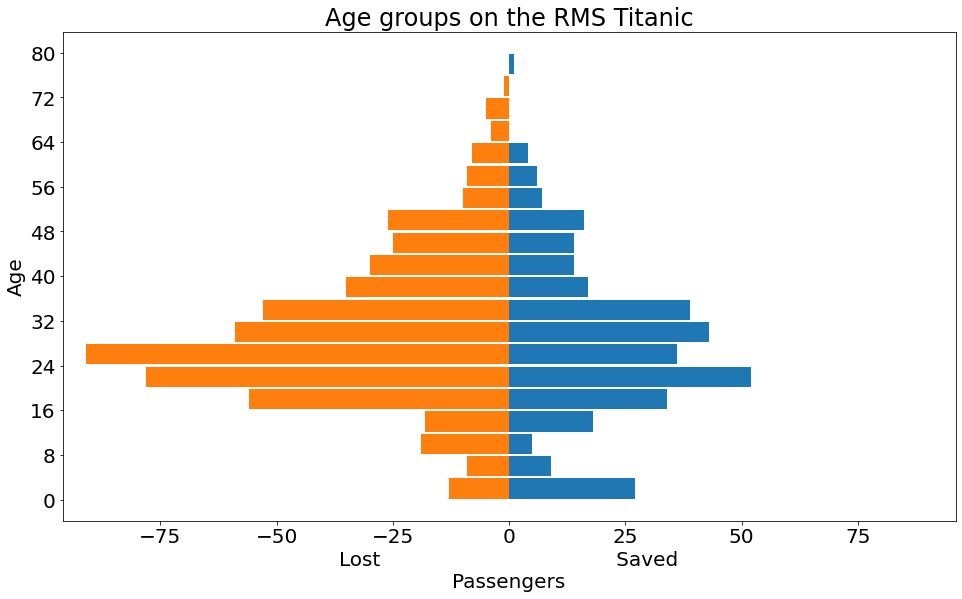

In [45]:
dig_sur = np.digitize(df[df['Survived'] == 1]['Age'],bins,right=True)
freq_sur = np.bincount(dig_sur,minlength=len(bins)+1)

dig_die = np.digitize(df[df['Survived'] == 0]['Age'],bins,right=True)
freq_die = np.bincount(dig_die,minlength=len(bins)+1)

xmax = freq_die.max()+5
xlim = [-xmax,xmax]

plt.figure(figsize=(16,9))
plt.barh(bins+binwidth/2,freq_sur[1:],height=binwidth*0.9)
plt.barh(bins+binwidth/2,-freq_die[1:],height=binwidth*0.9)
plt.xlim(xlim)
plt.yticks(np.arange(0,88,8))
plt.title('Age groups on the RMS Titanic')
plt.ylabel('Age')
plt.xlabel('Lost                                     Saved\nPassengers')
plt.savefig('agegroups.png',bbox_inches='tight',dpi=300)
plt.show()

There are three groups that seem to have a correlation with surviving or not surviving. First, those between the ages of 0 and 7 seem to survive more often than not. This could be the result that young people take up less room on lifeboats and they're pretty cute. 

Second, is the group of people age 20-27. Their fate seems to be tragic. This age group appears to correlate with not surviving. It could be that these people are full-grown adults but may not have a family of their own yet and therefore a liability. I suspect that males in this age group have sour odds.

Finally, the age group 36-44 also seems to correlate with not surviving. Perhaps this group of people has already raised their children who are now grown and independent. Obsolescence.

Let's check the pearson scores against my interpretation of this graphic.

In [46]:
# Initialize an array to hold which age group each passenger belongs to.
age_arr = np.zeros((len(df),len(bins)+1))

# Fill the array with the age group indicator for each passenger
for i in range(0,len(df)):
    for j in range(0,len(bins)):
        if (df['Age'][i] > bins[j]) & (df['Age'][i] <= bins[j]+binwidth):
            age_arr[i,j] = 1
            break
            
# Let's have a look 
print(bins.astype(int))
print(age_arr[0:10].astype(int))

[ 0  4  8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76]
[[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [47]:
bins = np.arange(0,ylim,binwidth)
X = age_arr
total = 0
for i in range(0,age_arr.shape[1]):
    significant = False
    if stats.pearsonr(X[:,i],y)[1] < 0.05:
        significant = True
        print(f'i = {i}')
        print(f'Age {bins[i]:.1f} : {bins[i]+binwidth:.1f} ')
        print(f'\tcorr {stats.pearsonr(X[:,i],y)[0]:.3f}')
        print(f'\tp-value {stats.pearsonr(X[:,i],y)[1]:.3e}')
        print(f'\tSignificant: {significant}')
        print(f'\tPassengers: {np.sum(X[:,i])}')
        model.append(f'{bins[i]:.0f}_{bins[i]+binwidth:.0f}')
        total = total + np.sum(X[:,i])
        print('+------------------------+')       

print(total)

i = 0
Age 0.0 : 4.0 
	corr 0.130
	p-value 1.021e-04
	Significant: True
	Passengers: 40.0
+------------------------+
i = 6
Age 24.0 : 28.0 
	corr -0.084
	p-value 1.198e-02
	Significant: True
	Passengers: 127.0
+------------------------+
167.0


/usr/pkg/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


#### Discussion

There are two age groups that have a statistically significant correlation with survival on the RMS Titanic. Those age 0 - 9 are correlated with surviving. Those age 18-27 are correlated with not surviving. There are no other age groups that have a correlation at this confidence level.

In [48]:
model

['male',
 'port_Q',
 'port_S',
 'deck_?',
 'deck_B',
 'deck_C',
 'deck_D',
 'deck_E',
 '0_4',
 '24_28']

# BY TICKET PREFIX

Some tickets have a prefix. Maybe they mean something that could have an effect on whether or not the passenger survived. Let's peel off the prefixes and take a look.

In [49]:
def get_prefix(PD_SERIES):
    splt = PD_SERIES.split(' ')
    tmp = splt
    if len(splt) > 1:      
        tmp = splt[0]
        tmp = tmp.replace('STON/O2','SOTON/O2')
        tmp = tmp.replace('STON/O','SOTON/O2')
        tmp = tmp.replace('O2.','O2')

        tmp = tmp.upper()
    else:
        tmp = ''
    return tmp

In [50]:
df['Ticket'].apply(get_prefix).value_counts()


              665
PC             60
C.A.           27
SOTON/O2       20
A/5            10
SC/PARIS        9
W./C.           9
SOTON/O.Q.      8
CA.             8
SOTON/OQ        7
A/5.            7
CA              6
C               5
S.O.C.          5
F.C.C.          5
PP              3
A/4             3
SC/AH           3
A/4.            3
S.O./P.P.       3
A.5.            2
S.C./PARIS      2
P/PP            2
WE/P            2
A./5.           2
C.A./SOTON      1
FA              1
F.C.            1
A4.             1
W/C             1
SO/C            1
A/S             1
S.O.P.          1
W.E.P.          1
S.C./A.4.       1
SC              1
S.W./PP         1
S.P.            1
SW/PP           1
SCO/W           1
Name: Ticket, dtype: int64

#### Discussion

This is a waste of time. There aren't enough passengers with any specific prefix to make any meaningful inference about the group.

# BY TITLE

Each passenger has a title preceding his or her name. Perhaps the passenger's title is correlated with survival. We did find correlation for sex and age. This has an air of linear dependence, but let's look anyway.

In [51]:
# Peel off and count titles
df['title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].replace(' ',''))
df['title'].value_counts()

Mr             517
Miss           182
Mrs            125
Master          40
Dr               7
Rev              6
Col              2
Mlle             2
Major            2
Sir              1
Mme              1
theCountess      1
Jonkheer         1
Ms               1
Capt             1
Don              1
Lady             1
Name: title, dtype: int64

In [52]:
# Group up some of the less common titles
miss = ['Ms','Mlle']
mrs = ['Mme', 'Lady']
prestigious = ['Dr','Rev','Major','Col','Sir','theCountess','Capt','Jonkheer','Don']

df['title'] = df['title'].replace(miss,'Miss')
df['title'] = df['title'].replace(mrs,'Mrs')
df['title'] = df['title'].replace(prestigious,'Prestigious')
df['title'].value_counts()

Mr             517
Miss           185
Mrs            127
Master          40
Prestigious     22
Name: title, dtype: int64

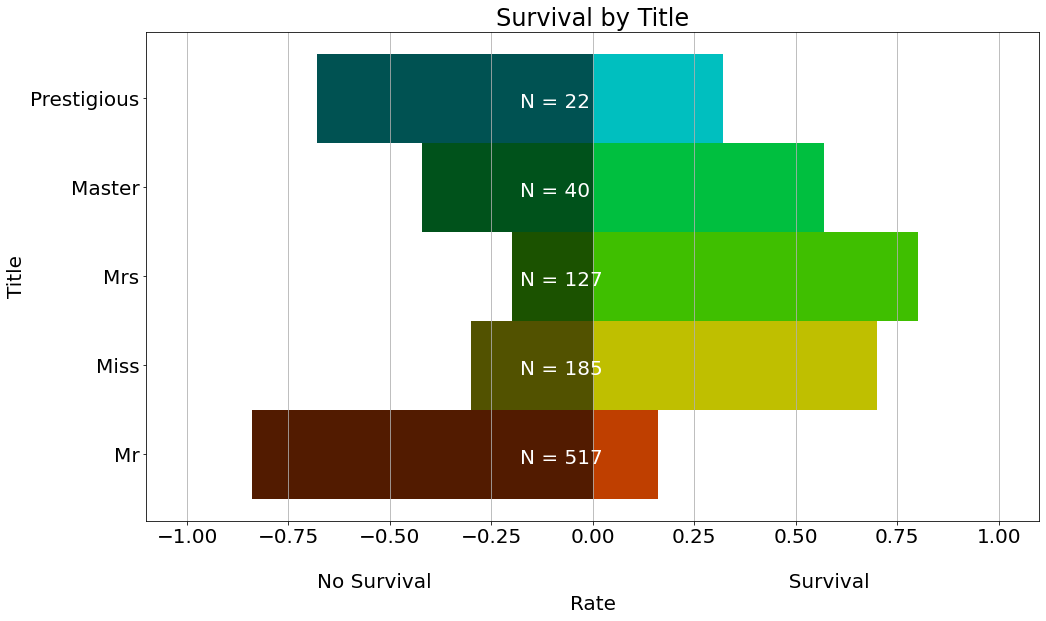

In [53]:
# Creating an array to hold the titles and whether or not they surived.
titles = df['title'].value_counts().index.tolist()
bytitle = np.zeros((len(titles),2))
# Populate the array
for i in range(0,len(titles)):
    bytitle[i] = df[df['title'] == titles[i]]['Survived'].value_counts().sort_index()

### Visualizing survival vs title

#Define some parameters for the graph
x = np.arange(-2.0,2.0)  # the label locations
width = 5.0  # the width of the bars

# Create some axes
fig, ax = plt.subplots(figsize=(16,9))
rects = []
# PLOT!
for i in range(0,len(titles)):
    b = plt.barh(i, np.round(bytitle[i,1]/np.sum(bytitle[i]),2), width/5, label=titles[i],color=rgb_list[2*i])
    nb = plt.barh(i, -np.round(bytitle[i,0]/np.sum(bytitle[i]),2), width/5, label=titles[i],color=rgb_list[2*i+1])
    rects.append(b)
    plt.annotate(f'N = {str(int(np.sum(bytitle[i])))}',xy=[-0.18,i-0.1],c='white')
ax.set_xlabel('\nNo Survival                                                        Survival\nRate')
ax.set_ylabel('Title')
ax.set_title('Survival by Title')
ax.set_yticks(range(0,len(titles)))
ax.set_xlim(-1.1,1.1)
ax.set_yticklabels(titles)
ax.grid(axis='x')
plt.show()

It appears that there is no correlation with having a prestigious title and surviving or not. Also it appears that having any title except Mr. is correlated with surviving. Mr is strongly correlated with drowning/hypothermia. Let's calculate the pearson R for confirmation.

In [54]:
# Prepare an array to hold our data
tit_arr = np.zeros((len(df),len(titles)))

# Populate array with title indicators
for i in range(0,len(df)):
    for j in range(0,len(titles)):
        if df['title'][i] == titles[j]:
            tit_arr[i,j] = 1
            break
tit_arr[0:5]

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [55]:
# Here I loop through the title array.
# Each title is checked for correlation with the Survived variable.

X = tit_arr
total = 0
for i in range(0,tit_arr.shape[1]):
    significant = False
    if stats.pearsonr(X[:,i],y)[1] < 0.05:
        significant = True
        print(f'i = {i}')
        print(f'Title {titles[i]} ')
        print(f'\tcorr {stats.pearsonr(X[:,i],y)[0]:.2f}')
        print(f'\tp-value {stats.pearsonr(X[:,i],y)[1]:.1e}')
        print(f'\tSignificant: {significant}')
        print(f'\tPassengers: {np.sum(X[:,i])}')
        model.append(f'{titles[i]}')
        total = total + np.sum(X[:,i])
        print('+------------------------+')       

print(total)

i = 0
Title Mr 
	corr -0.55
	p-value 2.4e-71
	Significant: True
	Passengers: 517.0
+------------------------+
i = 1
Title Miss 
	corr 0.34
	p-value 6.7e-25
	Significant: True
	Passengers: 185.0
+------------------------+
i = 2
Title Mrs 
	corr 0.34
	p-value 2.7e-26
	Significant: True
	Passengers: 127.0
+------------------------+
i = 3
Title Master 
	corr 0.09
	p-value 1.1e-02
	Significant: True
	Passengers: 40.0
+------------------------+
869.0


In [56]:
model

['male',
 'port_Q',
 'port_S',
 'deck_?',
 'deck_B',
 'deck_C',
 'deck_D',
 'deck_E',
 '0_4',
 '24_28',
 'Mr',
 'Miss',
 'Mrs',
 'Master']

# BY SIBSP

In [57]:
df['SibSp'].value_counts().sort_index().tolist()

[608, 209, 28, 16, 18, 5, 7]

In [58]:
sbsps = np.array(df['SibSp'].value_counts().sort_index().index)
bysbsp = np.zeros([len(sbsps),2])
for i in range(0,len(sbsps)):
    bysbsp[i] = df[df['SibSp'] == sbsps[i]]['Survived'].value_counts().sort_index()

In [59]:
print('Survival rate of SibSp')
for i in range(0,len(sbsps)):
    print(f'\t = {sbsps[i]}: {bysbsp[i][1]/np.sum(bysbsp[i]):.2f}')

Survival rate of SibSp
	 = 0: 0.35
	 = 1: 0.54
	 = 2: 0.46
	 = 3: 0.25
	 = 4: 0.17
	 = 5: 0.50
	 = 8: 0.50


In [60]:
ssp_arr = np.zeros((len(df),len(sbsps)))
for i in range(0,len(df)):
    for j in range(0,len(sbsps)):
        if df['SibSp'][i] == sbsps[j]:
            ssp_arr[i,j] = 1
            break
ssp_arr[0:5]

array([[0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]])

In [61]:
X = ssp_arr
total = 0
for i in range(0,ssp_arr.shape[1]):
    significant = False
    if stats.pearsonr(X[:,i],y)[1] < 0.05:
        significant = True
        print(f'i = {i}')
        print(f'SibSp: {sbsps[i]} ')
        print(f'\tcorr {stats.pearsonr(X[:,i],y)[0]:.2f}')
        print(f'\tp-value {stats.pearsonr(X[:,i],y)[1]:.1e}')
        print(f'\tSignificant: {significant}')
        print(f'\tPassengers: {np.sum(X[:,i])}')
        model.append(f'sbsp_{sbsps[i]}')
        total = total + np.sum(X[:,i])
        print('+------------------------+')       

print(total)

i = 0
SibSp: 0 
	corr -0.12
	p-value 5.3e-04
	Significant: True
	Passengers: 608.0
+------------------------+
i = 1
SibSp: 1 
	corr 0.17
	p-value 2.0e-07
	Significant: True
	Passengers: 209.0
+------------------------+
i = 6
SibSp: 8 
	corr -0.07
	p-value 3.6e-02
	Significant: True
	Passengers: 7.0
+------------------------+
824.0


In [62]:
model

['male',
 'port_Q',
 'port_S',
 'deck_?',
 'deck_B',
 'deck_C',
 'deck_D',
 'deck_E',
 '0_4',
 '24_28',
 'Mr',
 'Miss',
 'Mrs',
 'Master',
 'sbsp_0',
 'sbsp_1',
 'sbsp_8']

# BY PARCH

In [63]:
parchs = np.array(df['Parch'].value_counts().sort_index().index)
byparch = np.zeros([len(parchs),2])
for i in range(0,len(parchs)):
    byparch[i] = df[df['Parch'] == parchs[i]]['Survived'].value_counts().sort_index()

In [64]:
print('Survival rate of: Parch')
for i in range(0,len(parchs)):
    print(f'\t = {parchs[i]}: {byparch[i][1]/np.sum(byparch[i]):.2f}')

Survival rate of: Parch
	 = 0: 0.34
	 = 1: 0.55
	 = 2: 0.50
	 = 3: 0.60
	 = 4: 0.50
	 = 5: 0.20
	 = 6: 0.50


In [65]:
pch_arr = np.zeros((len(df),len(parchs)))
for i in range(0,len(df)):
    for j in range(0,len(parchs)):
        if df['Parch'][i] == parchs[j]:
            pch_arr[i,j] = 1
            break
pch_arr[0:5]

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]])

In [66]:
X = pch_arr
total = 0
for i in range(0,pch_arr.shape[1]):
    significant = False
    if stats.pearsonr(X[:,i],y)[1] < 0.05:
        significant = True
        print(f'i = {i}')
        print(f'Parch: {parchs[i]} ')
        print(f'\tcorr {stats.pearsonr(X[:,i],y)[0]:.2f}')
        print(f'\tp-value {stats.pearsonr(X[:,i],y)[1]:.1e}')
        print(f'\tSignificant: {significant}')
        print(f'\tPassengers: {np.sum(X[:,i])}')
        model.append(f'pa_{parchs[i]}')
        total = total + np.sum(X[:,i])
        print('+------------------------+')       

print(total)

i = 0
Parch: 0 
	corr -0.15
	p-value 1.0e-05
	Significant: True
	Passengers: 678.0
+------------------------+
i = 1
Parch: 1 
	corr 0.13
	p-value 5.9e-05
	Significant: True
	Passengers: 118.0
+------------------------+
i = 2
Parch: 2 
	corr 0.08
	p-value 2.5e-02
	Significant: True
	Passengers: 80.0
+------------------------+
876.0


# BY PCLASS

In [67]:
pcls = np.array(df['Pclass'].value_counts().sort_index().index)
pcls

array([1, 2, 3])

In [68]:
pcls_arr = np.zeros((len(df),len(pcls)))
for i in range(0,len(df)):
    for j in range(0,len(pcls)):
        if df['Pclass'][i] == pcls[j]:
            pcls_arr[i,j] = 1
            break
pcls_arr[0:5]

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [69]:
X = pcls_arr
total = 0
for i in range(0,pcls_arr.shape[1]):
    significant = False
    if stats.pearsonr(X[:,i],y)[1] < 0.05:
        significant = True
        print(f'i = {i}')
        print(f'Pclass: {pcls[i]} ')
        print(f'\tcorr {stats.pearsonr(X[:,i],y)[0]:.2f}')
        print(f'\tp-value {stats.pearsonr(X[:,i],y)[1]:.1e}')
        print(f'\tSignificant: {significant}')
        print(f'\tPassengers: {np.sum(X[:,i])}')
        model.append(f'class_{pcls[i]}')
        total = total + np.sum(X[:,i])
        print('+------------------------+')       

print(total)

i = 0
Pclass: 1 
	corr 0.29
	p-value 3.2e-18
	Significant: True
	Passengers: 216.0
+------------------------+
i = 1
Pclass: 2 
	corr 0.09
	p-value 5.3e-03
	Significant: True
	Passengers: 184.0
+------------------------+
i = 2
Pclass: 3 
	corr -0.32
	p-value 5.5e-23
	Significant: True
	Passengers: 491.0
+------------------------+
891.0


# Modeling

Below I use the information gleaned from exploration to build a model of who survives the disaster based upon variables considered to be most signicant. A function is defined to create an array of 0s and 1s from a dataframe which indicate whether or not the passenger has this particular feature. The array is then used to fit a logistic regression model. 

In [70]:
model

['male',
 'port_Q',
 'port_S',
 'deck_?',
 'deck_B',
 'deck_C',
 'deck_D',
 'deck_E',
 '0_4',
 '24_28',
 'Mr',
 'Miss',
 'Mrs',
 'Master',
 'sbsp_0',
 'sbsp_1',
 'sbsp_8',
 'pa_0',
 'pa_1',
 'pa_2',
 'class_1',
 'class_2',
 'class_3']

In [71]:
# View the format of the model array
pd.DataFrame(columns=model)

,male,port_Q,port_S,deck_?,deck_B,deck_C,deck_D,deck_E,0_4,24_28,...,Master,sbsp_0,sbsp_1,sbsp_8,pa_0,pa_1,pa_2,class_1,class_2,class_3


In [72]:
def initialize_model(dataframe):
    model_arr = np.zeros((len(dataframe),len(model)),dtype=int)
    for i in range(0,len(dataframe)):
        
        ### SEX
        model_arr[i,0] = (dataframe['Sex'][i] == 'male')        
        
        ### PORT
        #if dataframe['Embarked'][i] == 'Q':
        #    model_arr[i,1] = 1
        if dataframe['Embarked'][i] == 'S':
            model_arr[i,2] = 1    
        
        ### DECK
        dataframe['Cabin'].replace(np.nan,'??',inplace=True)
        dataframe['deck'] = dataframe['Cabin'].apply(get_deck)
        if dataframe['deck'][i] == '?':
            model_arr[i,3] = 1
        if dataframe['deck'][i] == 'B':
            model_arr[i,4] = 1
        if dataframe['deck'][i] == 'C':
            model_arr[i,5] = 1
        if dataframe['deck'][i] == 'D':
            model_arr[i,6] = 1
        if dataframe['deck'][i] == 'E':
            model_arr[i,7] = 1
        

        
        ### TITLE
        miss = ['Ms','Mlle']
        mrs = ['Mme', 'Lady']
        dataframe['title'] = dataframe['Name'].apply(lambda x: x.split(',')[1].split('.')[0].replace(' ',''))
        dataframe['title'] = dataframe['title'].replace(miss,'Miss')
        dataframe['title'] = dataframe['title'].replace(mrs,'Mrs')
        if dataframe['title'][i] == 'Mr':
            model_arr[i,8] = 1
        if dataframe['title'][i] == 'Miss':
            model_arr[i,9] = 1
        if dataframe['title'][i] == 'Mrs':
            model_arr[i,10] = 1
        #if dataframe['title'][i] == 'Master':
        #    model_arr[i,11] = 1
        
        ### SIBSP
        if dataframe['SibSp'][i] == 0:
            model_arr[i,12] = 1        
        if dataframe['SibSp'][i] == 1:
            model_arr[i,13] = 1   
        #if dataframe['SibSp'][i] == 8:
        #   model_arr[i,14] = 1
        
        ### PARCH
        if dataframe['Parch'][i] == 0:
            model_arr[i,15] = 1                       
        if dataframe['Parch'][i] == 1:
            model_arr[i,16] = 1         
        #if dataframe['Parch'][i] == 2:
        #    model_arr[i,17] = 1
        
        ### PCLASS
        if dataframe['Pclass'][i] == 1:
            model_arr[i,18] = 1
        #if dataframe['Pclass'][i] == 2:
        #    model_arr[i,19] = 1             
        if dataframe['Pclass'][i] == 3:
            model_arr[i,20] = 1 
            
        ### AGE
        if dataframe['Age'].isnull().any():
            nullage = dataframe[dataframe['Age'].isnull()].index.tolist() # Bookmark indices of NaNs
            df2 = dataframe.loc[:,['Pclass','Sex','SibSp','Parch','Fare','Embarked','Age']]

            df2['Sex'].replace(['female','male'],[0,1],inplace=True)
            df2['Embarked'].replace(['C','Q','S'],[0,1,2],inplace=True)

            X = np.array(df2[df2['Age'].isnull()])
            X = scaler.transform(X[:,:6])
            dataframe.iloc[nullage,5] = knn.predict(X) # Use the same model we built earlier to estimate age
      
        if (dataframe['Age'][i] > 0) & (df['Age'][i] <= 4):
            model_arr[i,21] = 1
            
        #if (dataframe['Age'][i] > 32) & (df['Age'][i] <= 36):
        #    model_arr[i,22] = 1
        
    return model_arr            

In [73]:
# Load the dataframe and initialize the model array
df_train = pd.read_csv('train.csv')
train_arr = initialize_model(df_train)
print(train_arr[0:5])

[[1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0]
 [0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0]
 [1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0]]


Training Set
	f1-score: 0.74
	acc. score: 0.80

Competition Set
	Accuracy: 0.897
	f1-score: 0.855


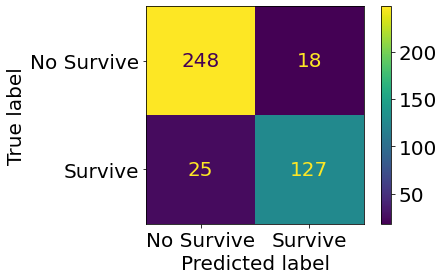

In [78]:
# Define the model input
X = train_arr
y = np.array(df_train['Survived'])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)


# define the model
clf_log = LogisticRegression(multi_class='multinomial',class_weight=None,solver='newton-cg',max_iter=100)
clf_log.fit(X_train, y_train)

# Score the model
print('Training Set')
print(f'\tf1-score: {f1_score(y_test,clf_log.predict(X_test)):.2f}')
print(f'\tacc. score: {accuracy_score(y_test,clf_log.predict(X_test)):.2f}\n')

# Load the competition set
df_test = pd.read_csv('test.csv')
df_true = pd.read_csv('gender_submission.csv')

# Initialize the competition data
test_arr = initialize_model(df_test)

# Predict survival of competition data and score
print('Competition Set')
print(f'\tAccuracy: {accuracy_score(df_true.iloc[:,1],clf_log.predict(test_arr)):.3f}')
print(f'\tf1-score: {f1_score(df_true.iloc[:,1],clf_log.predict(test_arr)):.3f}')


# Make a pretty picture
c_mat = confusion_matrix(df_true.iloc[:,1],clf_log.predict(test_arr))
disp = ConfusionMatrixDisplay(confusion_matrix = c_mat, display_labels=['No Survive','Survive'])
disp.plot(values_format='d')
plt.savefig('confusion.png',bbox_inches='tight',dpi=300)

In [74]:
# Prepare a dataframe to submit to Kaggle.com
df_submit = pd.DataFrame({'PassengerId':df_test['PassengerId'],'Survived':clf_log.predict(test_arr).tolist()})
df_submit.set_index('PassengerId',inplace=True)
df_submit.to_csv('kagglesubmission.csv')
df_submit[0:5]

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


## Rankings

Let's see how I did in the rankings.

In [80]:
# Load the leaderboard and print my rank.
df_leaderboard = pd.read_csv('./leaderboard/titanic-publicleaderboard.csv')
df_leaderboard[df_leaderboard['TeamName'] == 'Joey #5']

,TeamId,TeamName,SubmissionDate,Score
5065,5676964,Joey #5,2021-01-13 16:48:41,0.78468


Now visualize with a histogram.

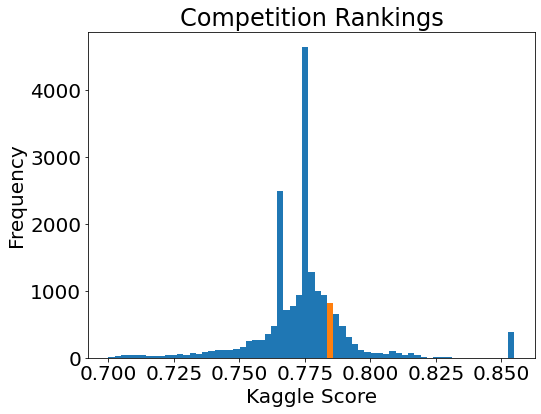

In [82]:
# Define some parameters
nbins = 65 # Number of bins
ylim = 0.855 # Maximum value for the histogram's y-axis
ymin = 0.7 # Minimum value for the histogram's y-axis
binwidth= (ylim-ymin)/nbins # The width of each bin
bins = np.arange(0.7,ylim,binwidth) # An array of evenly spaced bins "binwidth" apart

# Prepare data
thedigital = np.digitize(df_leaderboard['Score'],bins,right=True) # assign each age to a bin
thecount = np.bincount(thedigital) # Count the members in each bin

# Create some axes
plt.figure(figsize=(8,6))

# Draw the bars
plt.bar(bins[0:35]+binwidth/2,thecount[1:36],width=binwidth,color = 'C0')
plt.bar(bins[35:36]+binwidth/2,thecount[36:37],width=binwidth,color = 'C1')
plt.bar(bins[36:]+binwidth/2,thecount[37:],width=binwidth,color = 'C0')

# Label
plt.xticklabels=bins[33:66]
plt.xlim=(0.7,0.85)
plt.title('Competition Rankings')
plt.ylabel('Frequency')
plt.xlabel('Kaggle Score')

# Save and view
plt.savefig('./kaggle.png',bbox_inches='tight',dpi=300)
plt.show()

Pretty good for first attempt at this competition.